# Causal and Network Analysis of Government Procurement Data with Corruption Perception Indices

### Set up Python Environment

In [5]:
import os
os.chdir("drive/MyDrive/GDrive_Private/corruption-net-causal/")

In [ ]:
!pip install -r requirements.txt

### 1. Preprocess Contracts with Spark
Objective
- 元の JSON（contracts.json）を読み込み
- 「調達元（bureau）」「受注先（supplier）」のペアを「行」に展開（explode）
- bureau から正規表現で国名（country）を取り出し、列に追加
- 最終的に "bureau","supplier","country" の CSV ファイル（または Parquet）として出力

Key Points
- explode：JSON 内の「配列」を“縦に伸ばして”テーブル化する操作
- regexp_extract + initcap：gov_japan→japanを抜き出し、Japan に変換
- これにより、後段の分析で「国ごと」「企業ごと」にグループ化しやすい形式が得られる

In [28]:
!python spark/process_contracts.py --input data/contracts.json --output data/processed_contracts.parquet

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/30 12:54:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/30 12:54:21 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [29]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode

# セッション作成
spark = SparkSession.builder.appName("ValidateStructure").getOrCreate()

# JSON読み込み（multiline = true）
df = spark.read.option("multiline", "true").json("data/contracts.json")

# awards を展開
exploded = df.select(
    col("buyer.id").alias("bureau"),
    explode("awards").alias("award")
)

# supplier.id を抽出（edgesを定義）
edges = exploded.select(
    "bureau",
    col("award.supplier.id").alias("supplier")
)

# 確認
edges.printSchema()
edges.show(truncate=False)


root
 |-- bureau: string (nullable = true)
 |-- supplier: string (nullable = true)

+-----------+-------------------+
|bureau     |supplier           |
+-----------+-------------------+
|gov_japan  |corp_global        |
|gov_japan  |corp_mitsui        |
|gov_japan  |corp_hitachi       |
|gov_kenya  |corp_global        |
|gov_kenya  |corp_nairobi       |
|gov_kenya  |corp_kenya_energy  |
|gov_mexico |corp_global        |
|gov_mexico |corp_mexico_telecom|
|gov_mexico |corp_mexico_health |
|gov_mexico |corp_mexico_energy |
|gov_germany|corp_siemens       |
|gov_germany|corp_bmw           |
|gov_germany|corp_global        |
|gov_india  |corp_tcs           |
|gov_india  |corp_global        |
|gov_india  |corp_health        |
|gov_france |corp_global        |
|gov_france |corp_defense       |
|gov_france |corp_health        |
|gov_brazil |corp_agriculture   |
+-----------+-------------------+
only showing top 20 rows



In [31]:
import pandas as pd

# Parquet から読み込み
df = pd.read_csv("data/processed_contracts.parquet/part-00000-83c48ef3-34ac-48eb-bd65-6c6770f62511-c000.csv")

# bureau ("gov_japan" など) から country を抜き出す
df["country"] = (
    df["bureau"]
      .str.extract(r"gov_(.+)", expand=False)  # "japan"
      .str.capitalize()                         # "Japan"
)

# Colab 用に保存
df.to_csv("data/processed_contracts_for_colab.csv", index=False)


### 2. Build Network in Neo4j
🧩 Using Neo4j Desktop to Load CSV and Execute Cypher

Objective
- Neo4j に CSV をインポートし、Buyer（政府機関）と Supplier（企業）のノードを作成
- [:AWARDED] リレーション（受注関係）でエッジをつなぐ
- GDS（Graph Data Science）プラグインを使い、
  - degree centrality（単純な「つながりの多さ」）
  - PageRank（グラフ理論で使う「重要度スコア」）
- をそれぞれノード属性として書き込む

Key Points
- グラフデータベース：ノード（点）とエッジ（線）で関係性を扱うデータベース
- Degree centrality：あるノードが何本の線に繋がっているかを比率化したもの
- PageRank：Google の検索順位にも使われる、つながる相手の重要度も踏まえたスコア

#### Step 1: Install and Launch Neo4j Desktop

- Download from: https://neo4j.com/download/
- Create a new local project and database (e.g., `corruption-net`)
- Start the database


#### Step 2: Add CSV Files
Share the `processed_contracts.csv` (i.e., output from Spark) on the Google Drive and get the ID (xxxxxxxxxxxxxxx) from sharable link. Then, manually paste the following link for creating virtual graph: https://drive.google.com/uc?export=download&id=xxxxxxxxxxxxxxx

```cypher
// 既存の仮想グラフがあれば削除（オプション）
MATCH (n) DETACH DELETE n;
CALL gds.graph.list() YIELD graphName;
CALL gds.graph.drop('contractGraph', true);

// 仮想グラフ作成
LOAD CSV WITH HEADERS FROM 'https://drive.google.com/uc?export=download&id=119YKikkrBq_GiZvvpu4c8F00mumPE_uL'
AS row
MERGE (s:Supplier {id: row.supplier})
  ON CREATE SET s.country = row.country
  ON MATCH SET s.country  = coalesce(s.country, row.country)
MERGE (b:Buyer    {id: row.bureau})
MERGE (b)-[:AWARDED]->(s);

CALL gds.graph.project('contractGraph', ['Buyer', 'Supplier'], {
  AWARDED: {
    type: 'AWARDED',
    orientation: 'UNDIRECTED'
  }
});

// 中心性を計算
CALL gds.degree.write('contractGraph', {
  writeProperty: 'degree'
});

// ページランクを計算
CALL gds.pageRank.write('contractGraph', {
  maxIterations: 20,
  dampingFactor: 0.85,
  writeProperty: 'pagerank'
});

```

Neo4jで中心性を取得（Cypher）
```cypher
MATCH (s:Supplier)
RETURN s.id AS supplier, s.country AS country, s.pagerank AS pagerank, s.degree AS degree
ORDER BY s.pagerank DESC;
```
結果テーブルの右上「⋮」から 「Download CSV」 を選び、supplier_degree.csv などとして保存。Google Drive のresults下にアップロード。


### 3. Causal Inference with DoWhy (Google Colab)

Define treatment (e.g., `centrality`), outcome (e.g., `CPI`), and run estimation using DoWhy

Objective
- Neo4j で得た中心性スコア（たとえば pagerank）を「処置変数（treatment）」、CPI（Corruption Perception Index）を「結果変数（outcome）」として、因果関係の強さ（推定効果）を複数手法で比較

モデル
- 線形回帰: 連続値の pagerank と CPI の直線的な関係を当てはめる
- PSM（傾向スコアマッチング）:処置（高い vs 低い pagerank）を二値化し、似た条件同士を比較(「似たような背景の人同士をペアにして効果を比べる」)
- ForestDML（MetaLearner）: 因果森林と呼ばれる機械学習モデルで非線形／複雑な関係も検出可能。(「たくさんの木を育てて、その木々の判断を平均して予測する」)

In [32]:
import pandas as pd

# Google Drive連携
from google.colab import drive
drive.mount('/content/drive')

# データ読み込み
deg = pd.read_csv("results/supplier_degree.csv")
# cpi = pd.read_csv("data/corruption_scores.csv")
YEAR = 2017
import pandas as pd
df = pd.read_csv("data/corruption_scores.csv", sep=",", encoding="utf-8")
cpi = pd.DataFrame({
    "country":df["country"],
    "cpi_score": df[str(YEAR)]
})

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
# 仮に supplier ID に国名が含まれている場合（例：corp_mitsui → Japan）簡易マッピング
# deg["country"] = deg["s.country"].str.extract(r"_(\w+)$")  # 例: "corp_japan" → "japan"

# 結合
merged = pd.merge(deg, cpi, on="country")

In [34]:
print("Merged shape:", merged.shape)
print(merged.head())

Merged shape: (23, 5)
       supplier country  pagerank  degree  cpi_score
0   corp_global   Japan  3.622239    10.0        7.3
1   corp_global   Japan  3.622239    10.0        0.0
2   corp_health   India  1.085439     3.0        4.0
3  corp_defense  France  0.801503     2.0        7.0
4  corp_defense  France  0.801503     2.0        0.0


In [35]:
# 結合と前処理
merged = merged.dropna(subset=["pagerank", "cpi_score"])

# 確認
print(merged.shape)
print(merged[["pagerank", "cpi_score"]])

# 推定
from dowhy import CausalModel

model = CausalModel(
    data=merged,
    treatment="pagerank",
    outcome="cpi_score",
    common_causes=[]
)
identified_estimand = model.identify_effect()
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)
print("Estimated effect:", estimate.value)


(23, 5)
    pagerank  cpi_score
0   3.622239        7.3
1   3.622239        0.0
2   1.085439        4.0
3   0.801503        7.0
4   0.801503        0.0
5   0.786918        3.7
6   0.786918        2.7
7   0.530296        7.3
8   0.530296        0.0
9   0.530296        7.3
10  0.530296        0.0
11  0.530296        2.8
12  0.530296        2.8
13  0.530296        8.1
14  0.530296        8.1
15  0.529081        2.9
16  0.529081        2.9
17  0.529081        2.9
18  0.492940        3.7
19  0.492940        3.7
20  0.486945        3.7
21  0.486945        2.7
22  0.476903        4.0


Estimated effect: -0.07554776378920547


/usr/local/lib/python3.11/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


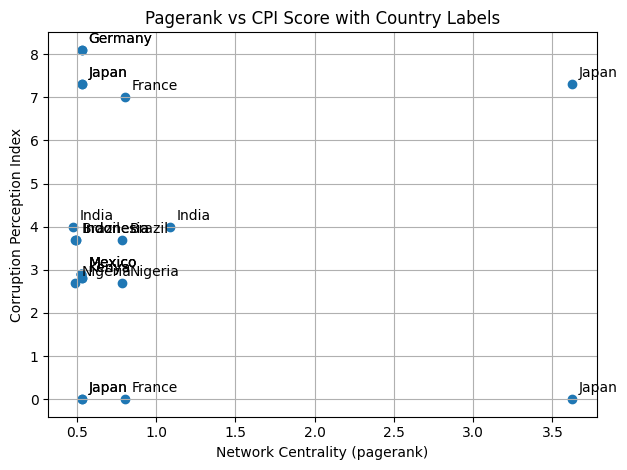

In [36]:
import matplotlib.pyplot as plt

x = merged["pagerank"]
y = merged["cpi_score"]
labels = merged["country"]

fig, ax = plt.subplots()
ax.scatter(x, y)

# 各点にラベルを付与
for i, label in enumerate(labels):
    ax.annotate(
        label,
        (x.iat[i], y.iat[i]),
        textcoords="offset points",
        xytext=(5, 5),
        ha="left"
    )

ax.set_xlabel("Network Centrality (pagerank)")
ax.set_ylabel("Corruption Perception Index")
ax.set_title("Pagerank vs CPI Score with Country Labels")
ax.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# 1) 二値化
merged["treatment_bin"] = (merged["pagerank"] > merged["pagerank"].median()).astype(int)

# 2) common_causes に degree を指定
common = ["degree"]

# 3) 手法ごとの設定
methods = {
    "Regression (continuous)": {
        "treatment": "pagerank",
        "method":    "backdoor.linear_regression"
    },
    "PSM (binary)": {
        "treatment": "treatment_bin",
        "method":    "backdoor.propensity_score_matching"
    },
    "MetaLearner": {
        "treatment": "pagerank",
        "method":    "backdoor.econml.dml.CausalForestDML"
    }
}

results = []
for country in merged["country"].unique():
    subset = merged[merged["country"] == country]
    for label, cfg in methods.items():
        model = CausalModel(
            data=subset,
            treatment=cfg["treatment"],
            outcome="cpi_score",
            common_causes=common
        )
        estimand = model.identify_effect()
        # PSM のみ例外的に fallback を設定
        try:
            est = model.estimate_effect(estimand, method_name=cfg["method"])
        except Exception:
            est = model.estimate_effect(
                estimand,
                method_name="backdoor.linear_regression"
            )
        results.append({
            "country":  country,
            "method":   label,
            "estimate": est.value
        })

df_res = pd.DataFrame(results)


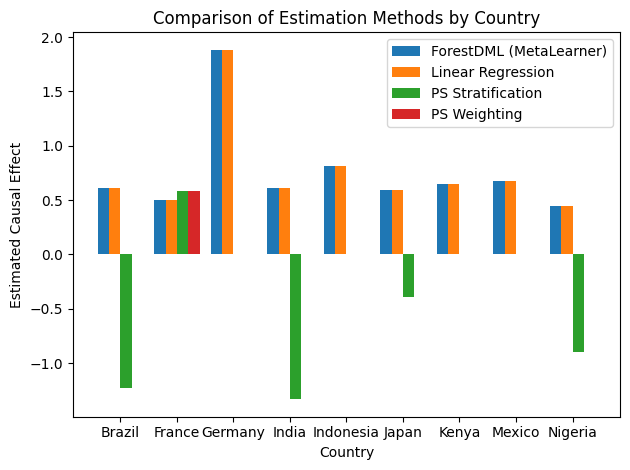

In [38]:
import warnings
import logging

# ———— ワーニング全般を非表示 ————
warnings.filterwarnings("ignore")

# ———— 各種ライブラリのログレベルをERRORに設定 ————
logging.getLogger("py4j").setLevel(logging.ERROR)
logging.getLogger("dowhy").setLevel(logging.ERROR)
logging.getLogger("econml").setLevel(logging.ERROR)
logging.getLogger("matplotlib").setLevel(logging.ERROR)
logging.getLogger("sklearn").setLevel(logging.ERROR)

import pandas as pd
from dowhy import CausalModel
import matplotlib.pyplot as plt

# merged: country, pagerank, cpi_score, degree, treatment_bin カラムを持つ DataFrame

# 各推定手法と method_name を設定
methods = {
    "Linear Regression":            "backdoor.linear_regression",
    "PS Stratification":            "backdoor.propensity_score_stratification",
    "PS Weighting":                 "backdoor.propensity_score_weighting",
    "ForestDML (MetaLearner)":      "backdoor.econml.dml.CausalForestDML"
}

results = []
common = ["degree"]  # 交絡因子

for country in merged["country"].unique():
    subset = merged[merged["country"] == country]
    # まずは二値化 treatment_bin, 連続は pagerank として扱う
    for label, method_name in methods.items():
        # 連続処理と二値処理、両方に対応させる
        treat = "treatment_bin" if "PS" in label else "pagerank"
        model = CausalModel(
            data=subset,
            treatment=treat,
            outcome="cpi_score",
            common_causes=common
        )
        estimand = model.identify_effect()
        try:
            est = model.estimate_effect(estimand, method_name=method_name)
        except Exception:
            # 万が一失敗したら線形回帰にフォールバック
            est = model.estimate_effect(
                estimand,
                method_name="backdoor.linear_regression"
            )
        results.append({
            "country": country,
            "method":  label,
            "estimate": est.value
        })

# DataFrame整形＆プロット
df_res = pd.DataFrame(results)
pivot = df_res.pivot(index="country", columns="method", values="estimate")

x = range(len(pivot))
width = 0.2
fig, ax = plt.subplots()
for i, method in enumerate(pivot.columns):
    ax.bar([xi + i*width for xi in x], pivot[method], width, label=method)

ax.set_xticks([xi + width*1.5 for xi in x])
ax.set_xticklabels(pivot.index)
ax.set_xlabel("Country")
ax.set_ylabel("Estimated Causal Effect")
ax.set_title("Comparison of Estimation Methods by Country")
ax.legend()
plt.tight_layout()
plt.show()
